In [196]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline

from numba import njit
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, TargetEncoder

from sklearn.linear_model import LinearRegression
from window_ops.rolling import rolling_mean
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

## Import MLForecast_Evaluator and helper functions:

In [197]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import the Evaluator class
from fao_utils import MLForecast_Evaluator, query_country

# Load data and preprocess it

In [198]:
data = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\full_country_dataset_v2_imputed.parquet')
data = data[data['Area Code'] > 1000]

In [199]:
projections = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\population_projections.parquet')
projections = projections[projections['Area Code'] > 1000]

In [200]:
projections

,Area Code,Area,Year,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No
2259,5000.0,World,2022,7975105.157
2260,5000.0,World,2023,8045311.446
2261,5000.0,World,2024,8118835.991
2262,5000.0,World,2025,8191988.467
2263,5000.0,World,2026,8264364.506
...,...,...,...,...
2563,5817.0,Net Food Importing Developing Countries,2029,2019256.383
2564,5817.0,Net Food Importing Developing Countries,2030,2057575.986
2573,5848.0,Annex I countries,2030,NaN
2582,5849.0,Non-Annex I countries,2030,NaN


In [201]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
data = data.rename(columns={"Area": "unique_id", "Year": "ds", 
                            "Total_Energy_Emissions_(CO2)_kt": "y",
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "y", "population_1000s"]
data = data[cols].dropna()

In [202]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
projections = projections.rename(columns={"Area": "unique_id", "Year": "ds", 
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "population_1000s"]
projections = projections[cols].dropna()

In [203]:
train_index = sorted(list(data["ds"].unique()))[:-5]
valid_index = sorted(list(data["ds"].unique()))[-5:]

In [204]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
valid

,unique_id,ds,y,population_1000s
10579,World,2017,915665.1706,7599822.416
10580,World,2018,914235.5448,7683789.830
10581,World,2019,926683.3158,7764951.042
10582,World,2020,888199.3907,7840952.880
10583,World,2021,888553.7285,7909295.146
...,...,...,...,...
11965,Net Food Importing Developing Countries,2017,44802.9324,1588752.415
11966,Net Food Importing Developing Countries,2018,49084.7623,1621174.421
11967,Net Food Importing Developing Countries,2019,50866.6240,1654068.503
11968,Net Food Importing Developing Countries,2020,41224.3586,1688373.378


In [205]:
# XGBRegressor
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    reg_lambda=1,
    random_state=42
)

# CatBoostRegressor
cb = CatBoostRegressor(
    iterations=100,
    depth=5,
    learning_rate=0.1,
    loss_function='RMSE',
    random_seed=42,
    silent=True
)

# List of models
models = [xgb, cb]

In [206]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq=1,
    lags=[1,2],
    lag_transforms={
        1: [
            (rolling_mean, 2),
            (diff, 1),
            ],
        2: [
            (rolling_mean, 2),
            (diff, 1),
            ],
        3: [
            (rolling_mean, 2),
            (diff, 1),
            ],
    },
    target_transforms=[GlobalSklearnTransformer(sk_log1p)],
    # target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    # target_transforms=[Differences([1])],

    num_threads=6
)

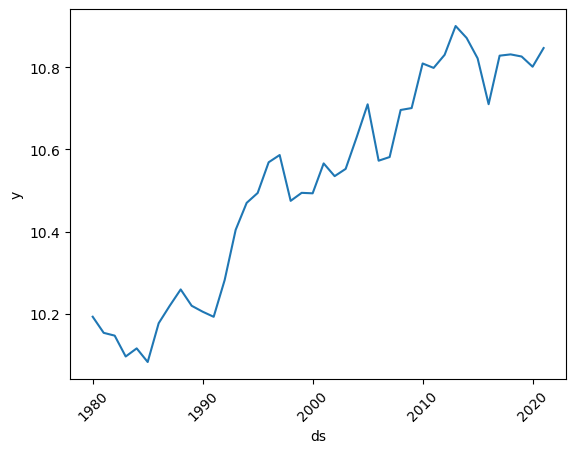

,unique_id,ds,y,population_1000s,lag1,lag2,rolling_mean_lag1_window_size2,diff_lag1_lag1,rolling_mean_lag2_window_size2,diff_lag2_lag1,rolling_mean_lag3_window_size2,diff_lag3_lag1
11004,South America,1980,10.192237,241789.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11005,South America,1981,10.152958,247206.134,10.192237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11006,South America,1982,10.146165,252673.356,10.152958,10.192237,10.172598,-0.039279,NaN,NaN,NaN,NaN
11007,South America,1983,10.095295,258200.232,10.146165,10.152958,10.149562,-0.006793,10.172598,-0.039279,NaN,NaN
11008,South America,1984,10.115088,263760.543,10.095295,10.146165,10.120730,-0.050870,10.149562,-0.006793,10.172598,-0.039279


In [207]:
transformed_data = fcst.preprocess(data, dropna=False)
query_country(transformed_data, unique_id ="South America", target_col="y").head()

In [208]:
transformed_data.drop(columns=['unique_id', 'ds']).corr()['y']

y                                 1.000000
population_1000s                  0.558835
lag1                              0.997110
lag2                              0.994357
rolling_mean_lag1_window_size2    0.996469
diff_lag1_lag1                   -0.017679
rolling_mean_lag2_window_size2    0.993904
diff_lag2_lag1                   -0.021683
rolling_mean_lag3_window_size2    0.991499
diff_lag3_lag1                   -0.023167
Name: y, dtype: float64

# Train and evaluate

In [211]:
from mlforecast.utils import PredictionIntervals

In [217]:
# train = train.drop("population_1000s", axis=1)
fcst.fit(train, fitted=True, static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=3, h=5, method="conformal_distribution"))

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=1, lag_features=['lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'diff_lag1_lag1', 'rolling_mean_lag2_window_size2', 'diff_lag2_lag1', 'rolling_mean_lag3_window_size2', 'diff_lag3_lag1'], date_features=[], num_threads=6)

In [218]:
# temp_transf = transform_exog(future_df, lags=[1,2], 
#                              lag_transforms={1: [ExpandingMean()]})

In [219]:
# future_df = pd.concat([valid, projections]).drop('y', axis=1)
future_df = valid.drop('y', axis=1)
future_df.shape

(165, 3)

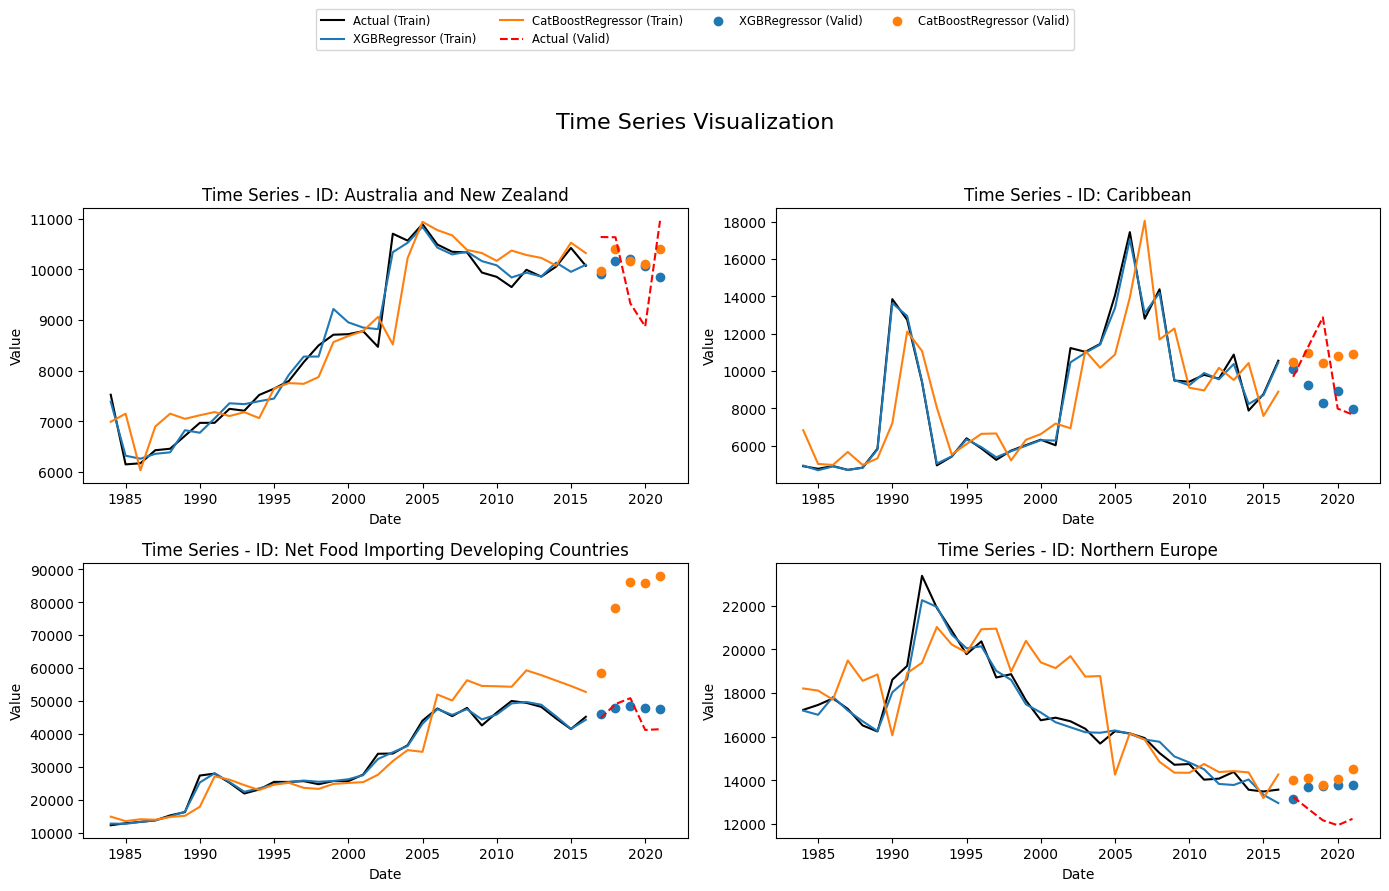

MEAN RMSE_VALID = 25660.827381190054

Model with lowest RMSE validation is XGBRegressor with RMSE = 13822.281875034254

                     RMSE_train  R2_train    RMSE_valid  R2_valid
XGBRegressor        3976.543488  0.999353  13822.281875  0.994287
CatBoostRegressor  20835.586989  0.982246  37499.372887  0.957948


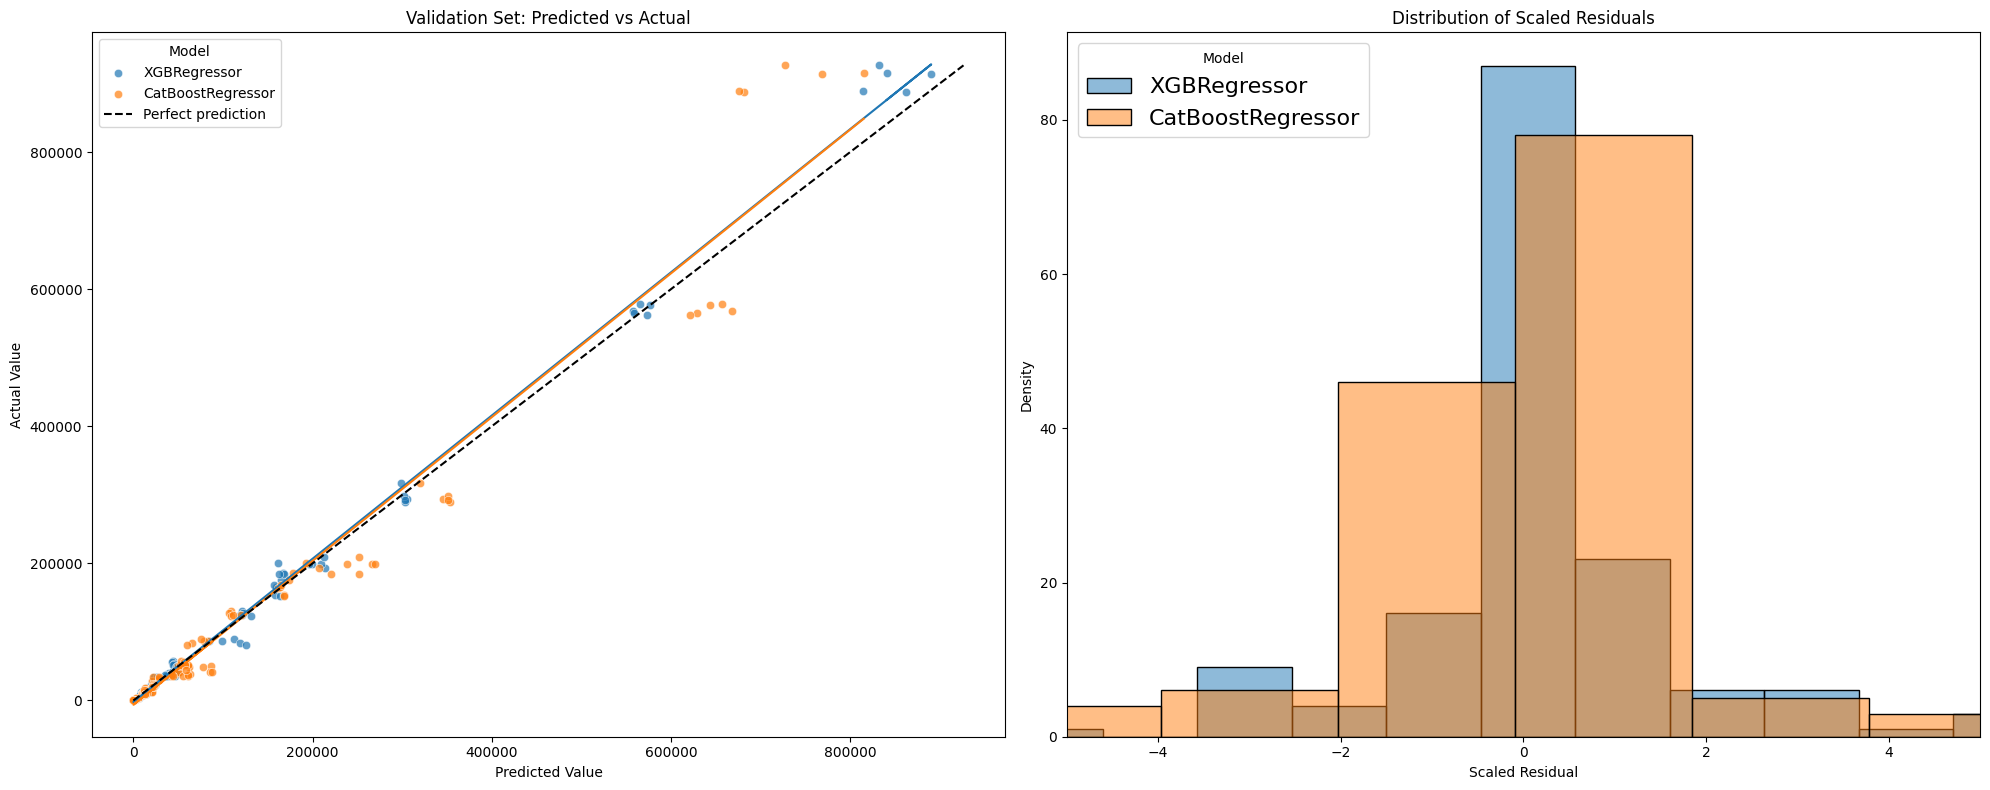

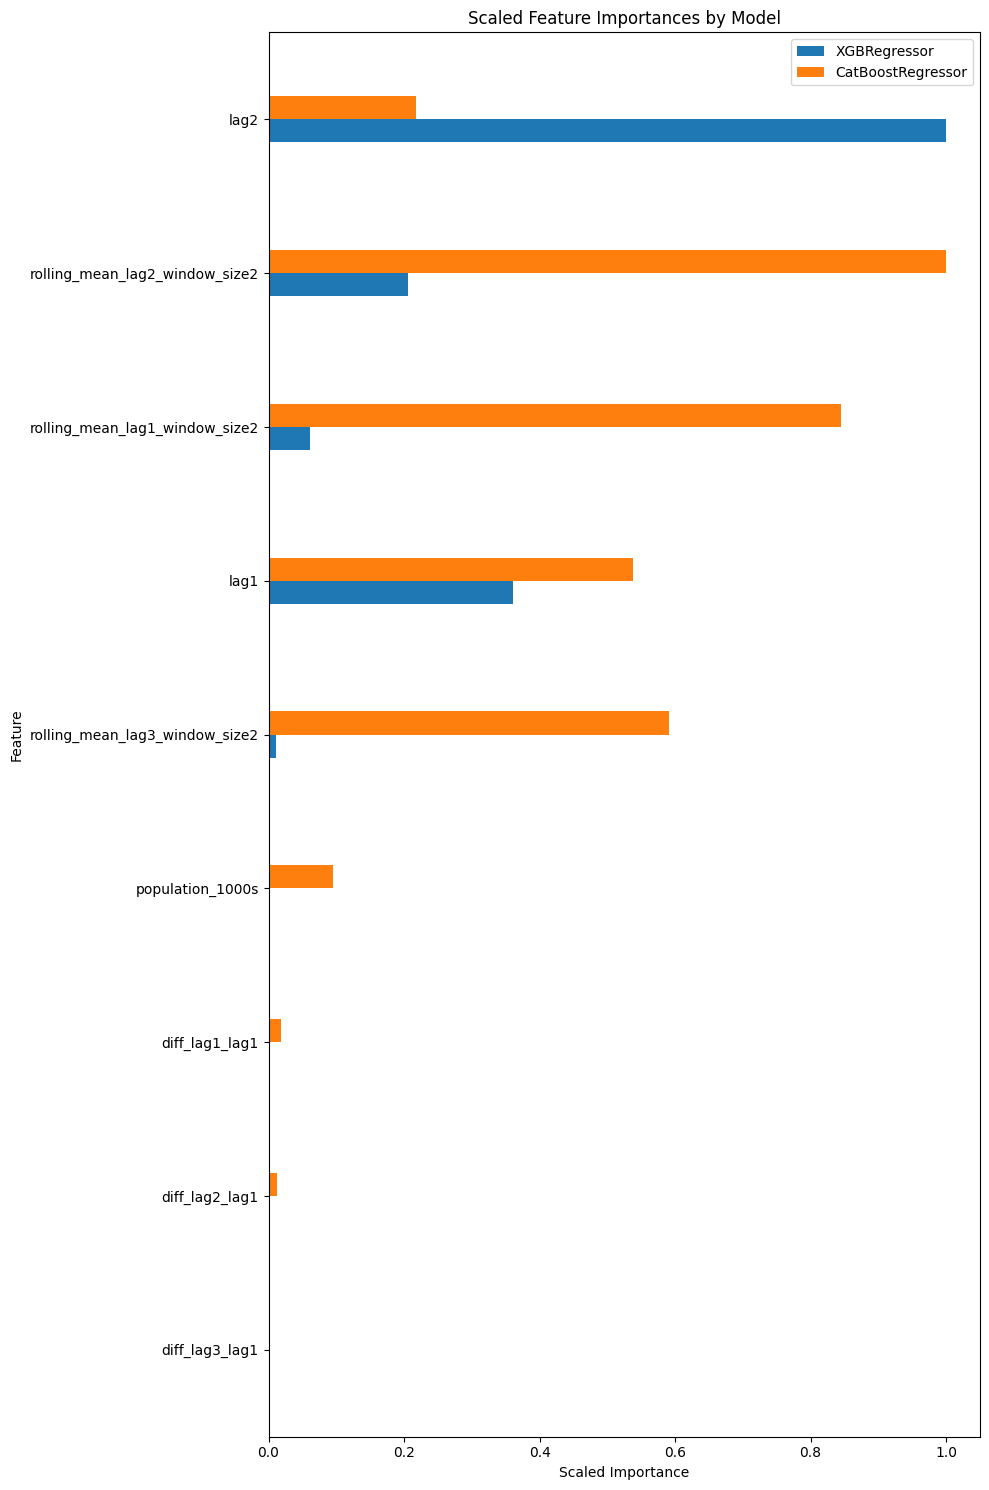

In [220]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=5)

# Plot time series
evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

In [237]:
df = fcst.predict(h=5, X_df=future_df, level=[60,80])
df

,unique_id,ds,XGBRegressor,CatBoostRegressor,XGBRegressor-lo-80,XGBRegressor-lo-60,XGBRegressor-hi-60,XGBRegressor-hi-80,CatBoostRegressor-lo-80,CatBoostRegressor-lo-60,CatBoostRegressor-hi-60,CatBoostRegressor-hi-80
0,Africa,2017,37687.644531,42262.918408,35080.824580,35814.864666,39560.424397,4.029446e+04,38320.655682,40633.597238,43892.239578,46205.181135
1,Africa,2018,39809.863281,49521.173464,35063.356970,36422.999897,43196.726666,4.455637e+04,40767.027797,46192.200126,52850.146801,58275.319131
2,Africa,2019,43212.460938,51179.580643,41180.706747,42251.331912,44173.589963,4.524422e+04,38293.284137,48195.703365,54163.457920,64065.877148
3,Africa,2020,46803.410156,60902.045451,37745.753800,37931.907025,55674.913287,5.586107e+04,32140.900570,43084.920104,78719.170798,89663.190332
4,Africa,2021,48567.917969,63212.811573,24601.866213,35480.815869,61655.020069,7.253397e+04,20359.427906,28297.605239,98128.017906,106066.195240
...,...,...,...,...,...,...,...,...,...,...,...,...
160,World,2017,841087.562500,815359.961736,785416.042700,789417.577900,892757.547100,8.967591e+05,766852.801773,785383.043472,845336.880001,863867.121699
161,World,2018,890673.000000,768386.976975,761249.781500,806136.912500,975209.087500,1.020096e+06,661564.802732,714456.303142,822317.650809,875209.151219
162,World,2019,832219.812500,726976.031610,752060.899550,797180.334600,867259.290400,9.123787e+05,591328.542450,636680.452522,817271.610698,862623.520770
163,World,2020,862292.312500,681530.243394,794206.754400,818680.889200,905903.735800,9.303779e+05,533353.387104,574856.916358,788203.570431,829707.099684


In [232]:
melted_df = df.melt(id_vars= ["ds", "unique_id"], var_name="pred", value_name="pred_value")
melted_df

,ds,unique_id,pred,pred_value
0,2017,Africa,XGBRegressor,37687.644531
1,2018,Africa,XGBRegressor,39809.863281
2,2019,Africa,XGBRegressor,43212.460938
3,2020,Africa,XGBRegressor,46803.410156
4,2021,Africa,XGBRegressor,48567.917969
...,...,...,...,...
985,2017,World,CatBoostRegressor-hi-40,834446.143160
986,2018,World,CatBoostRegressor-hi-40,812786.083654
987,2019,World,CatBoostRegressor-hi-40,808304.497637
988,2020,World,CatBoostRegressor-hi-40,787003.144182


<Axes: xlabel='ds', ylabel='pred_value'>

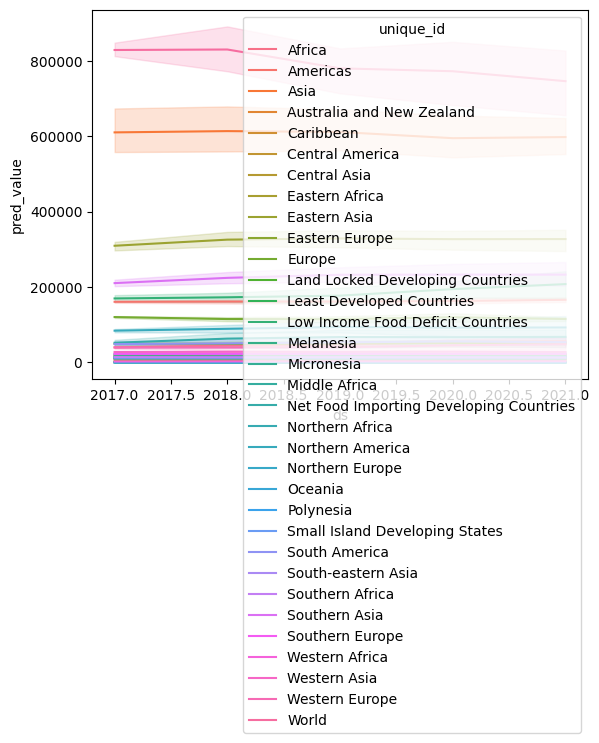

In [233]:
sns.lineplot(x="ds", y="pred_value", data=melted_df, hue="unique_id")